<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 3: Practical - PyTorch Classification <br>
<font color=696880 size=4>
    Javad Hezareh 
    
    
____


### Full Name : Zahra Soukhtedel
### Student Number : 98105138
___

# Problem
This assignment uses PyTorch to build and implement a MLP model for solving a classification problem. Our goal is to classify galaxy images into 4 classes: ellipticals, lenticulars, spirals, and irregulars. We will use [EFIGI](https://www.astromatic.net/projects/efigi/) dataset which contains 4458 images.

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [49]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################

from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Prepare and Visualize Data (10 Points)

Run the following cell to download dataset. `prepare_data` will return a pandas dataframe which contains three columns. `name` is the name of image that you can find that in `./efigi-1.6/png`, `class_name` is the type of galaxy in that image and `class_label` is a numerical label for this class.

In [39]:
# run this cell to download and prepare data
from data_utils import download_data, prepare_data

download_data()
df = prepare_data('./efigi-1.6/EFIGI_attributes.txt')

df.head()

,name,class_name,class_label
0,PGC0000212,Spirals,2
1,PGC0000218,Spirals,2
2,PGC0000243,Lenticulars,1
3,PGC0000255,Spirals,2
4,PGC0000281,Spirals,2


In [40]:

##############################################################
##            Visualize 4 sample from each class            ##
##                        Your Code                         ##
##############################################################


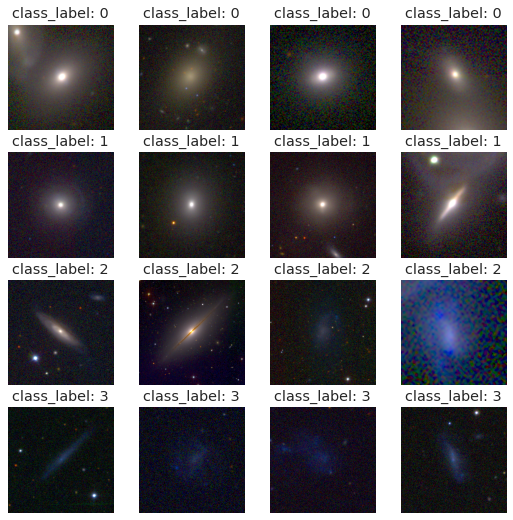

In [41]:

value = {}
for layer in range(len(self.layers)):
    v["dW" + str(layer + 1)] = np.zeros_like(layer.params["W"])
    v["db" + str(layer + 1)] = np.zeros_like(layer.params["b"])

for layer in self.layers:
    v["dW" + str(layer + 1)] = self._momentum() * v["dW" + str(layer + 1)] + (1 - self._momentum()) * layer.grads['W']
    v["db" + str(layer + 1)] = self._momentum() * v["db" + str(layer + 1)] + (1 - self._momentum()) * layer.grads['b']
    layer.params["W"] = layer.params["W"] - self.lr * v["dW" + str(layer + 1)]
    layer.params["b"] = layer.params["W"] - self.lr * v["db" + str(layer + 1)]


# Define Dataset (20 Points)

In [42]:
###############################################################
##        Write your dataset class for loading images        ##
##                        Your Code                          ##
###############################################################
import cv2 as cv


class GalaxyDataSetTransformer(Dataset):
    def __init__(self, base_dataset, transform):
        self.base_dataset = base_dataset
        self.transform = transform

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, index):
        img = cv.cvtColor(cv.imread('/content/efigi-1.6/png/' + self.base_dataset.iloc[index][0] + '.png'),
                          cv.COLOR_BGR2RGB)
        return self.transform(img), self.base_dataset.iloc[index][2]

#### split dataset into train, test and validation, and prepair them for learning process.


In [43]:
# spliting data 
#  parameters
test_ratio = 0.3
valid_ratio = 0.2

temp_dataset, test_dataset = train_test_split(df, test_size=test_ratio)
train_dataset, validation_dataset = train_test_split(temp_dataset, test_size=valid_ratio)

# prepairing for learning process
train_dataset = GalaxyDataSetTransformer(train_dataset, transforms.ToTensor())
validation_dataset = GalaxyDataSetTransformer(validation_dataset, transforms.ToTensor())
test_dataset = GalaxyDataSetTransformer(test_dataset, transforms.ToTensor())

#  parameters 
num_threads = 2
batch_size = 128

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=num_threads)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=num_threads)

validaition_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                                 batch_size=batch_size,
                                                 shuffle=False,
                                                 num_workers=num_threads)

hence we have:

In [44]:
print("The train set contains {} images, in {} batches".format(len(train_loader.dataset), len(train_loader)))
print("The validation set contains {} images, in {} batches".format(len(validaition_loader.dataset),
                                                                    len(validaition_loader)))
print("The test set contains {} images, in {} batches".format(len(test_loader.dataset), len(test_loader)))


The train set contains 2496 images, in 20 batches
The validation set contains 624 images, in 5 batches
The test set contains 1338 images, in 11 batches


# Define Model (20 Points)

In [45]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################
def linear_relu(dim_in, dim_out):
    return [nn.Linear(dim_in, dim_out), nn.ReLU(inplace=True)]


class ClassifierModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ClassifierModel, self).__init__()
        self.classifier = nn.Sequential(
            *linear_relu(input_size, 256),
            *linear_relu(256, 256),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = x.view(x.size()[0], -1)
        y = self.classifier(x)
        return y

# Train Model (30 Points)

In [46]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function ant etc                                     ##
######################################################################

def train(model, loader, f_loss, optimizer, device):
    model.train()
    for i, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # forward pass
        outputs = model(inputs)
        loss = f_loss(outputs, targets)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test(model, loader, f_loss, device):
    with torch.no_grad():
        model.eval()
        N = 0
        tot_loss, correct = 0.0, 0.0
        for i, (inputs, targets) in enumerate(loader):
            # We got a minibatch
            # shapes are as follows
            # inputs : (128, 1, 28, 28)
            # targets : (128)

            # We need to copy the data on the GPU if we use one
            inputs = inputs.to(device)
            targets = targets.to(device)

            #forward
            outputs = model(inputs)

            N += inputs.shape[0]

            tot_loss += inputs.shape[0] * f_loss(outputs, targets).item()

            predicted_targets = outputs.argmax(dim=1)
            correct += (predicted_targets == targets).sum().item()

        return tot_loss / N, correct / N


# model :
model = ClassifierModel(3 * 255 * 255, 4)
model.to(device)

# optimizer :
optimizer = torch.optim.Adam(model.parameters())

# loss function : 
f_loss = torch.nn.CrossEntropyLoss()




Epoch 0
 Training : Loss : 0.8975, Acc : 0.7316
 Validation : Loss : 0.9060, Acc : 0.7388
Epoch 1
 Training : Loss : 0.7827, Acc : 0.7476
 Validation : Loss : 0.8228, Acc : 0.7468
Epoch 2
 Training : Loss : 0.7233, Acc : 0.7704
 Validation : Loss : 0.8127, Acc : 0.7067
Epoch 3
 Training : Loss : 0.5516, Acc : 0.7728
 Validation : Loss : 0.6673, Acc : 0.7388
Epoch 4
 Training : Loss : 0.4792, Acc : 0.7969
 Validation : Loss : 0.6802, Acc : 0.7308
Epoch 5
 Training : Loss : 0.4775, Acc : 0.7821
 Validation : Loss : 0.7851, Acc : 0.7340
Epoch 6
 Training : Loss : 0.2721, Acc : 0.9203
 Validation : Loss : 0.6062, Acc : 0.7596
Epoch 7
 Training : Loss : 0.2009, Acc : 0.9511
 Validation : Loss : 0.6292, Acc : 0.7580
Epoch 8
 Training : Loss : 0.1577, Acc : 0.9740
 Validation : Loss : 0.6172, Acc : 0.7724
Epoch 9
 Training : Loss : 0.1228, Acc : 0.9712
 Validation : Loss : 0.7322, Acc : 0.7484


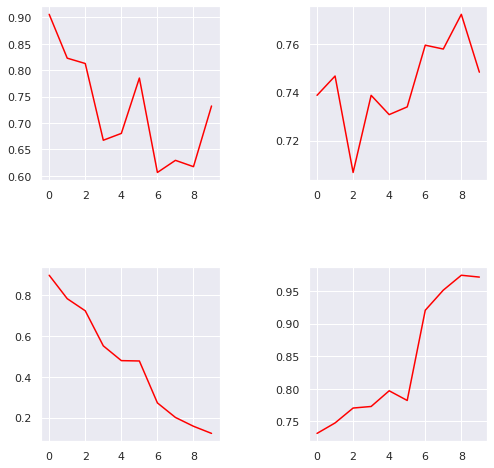

In [47]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################
def train_plot_metrics(epochs, model, optimizer):
    FC1 = []
    FC2 = []
    FC3 = []
    FC4 = []
    for t in range(epochs):
        print("Epoch {}".format(t))
        train(model, train_loader, f_loss, optimizer, device)
        val_loss, val_acc = test(model, validaition_loader, f_loss, device)
        train_loss, train_acc = test(model, train_loader, f_loss, device)
        FC1.append(val_loss)
        FC2.append(val_acc)
        FC3.append(train_loss)
        FC4.append(train_acc)
        print(" Training : Loss : {:.4f}, Acc : {:.4f}".format(train_loss, train_acc))
        print(" Validation : Loss : {:.4f}, Acc : {:.4f}".format(val_loss, val_acc))

    return FC1, FC2, FC3, FC4


epochs = 10
FC1, FC2, FC3, FC4 = train_plot_metrics(epochs, model, optimizer)

sns.set()
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
sns.lineplot(data=FC1, ax=axes[0, 0], color='red');
sns.lineplot(data=FC2, ax=axes[0, 1], color='red');
sns.lineplot(data=FC3, ax=axes[1, 0], color='red');
sns.lineplot(data=FC4, ax=axes[1, 1], color='red');

# Test Model (20)

test loss: 0.6101435577031921 , test acc: 0.7869955156950673


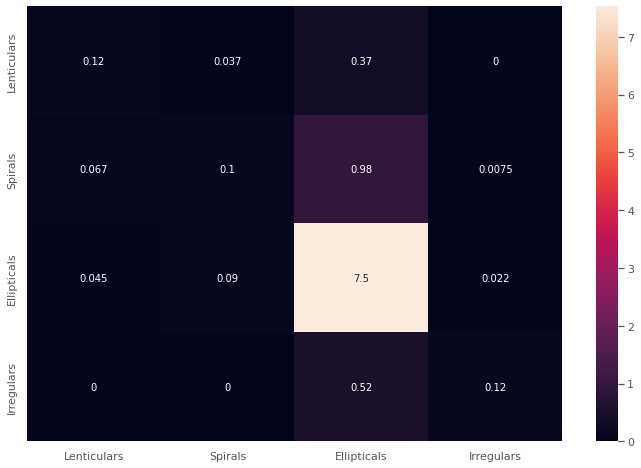

In [50]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################
def test_plot_confusion(model):
    test_loss, test_acc = test(model, test_loader, f_loss, device)
    print('test loss: ' + str(test_loss) + ' , test acc: ' + str(test_acc))

    y_pred = []
    y_true = []
    with torch.no_grad():
        model.eval()
        N = 0
        tot_loss, correct = 0.0, 0.0
        for i, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            output = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
            y_pred.extend(output)
            tot_loss += inputs.shape[0] * f_loss(outputs, targets).item()
            N += inputs.shape[0]
            targets = targets.data.cpu().numpy()
            y_true.extend(targets)
            inputs = inputs.data.cpu().numpy()

            correct += (output == targets).sum().item()
        test_loss, test_acc = tot_loss / N, correct / N

    # constant for classes
    classes = ('Lenticulars', 'Spirals', 'Ellipticals', 'Irregulars')

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix) * 10, index=[i for i in classes],
                         columns=[i for i in classes])
    plt.figure(figsize=(12, 8))
    sns.heatmap(df_cm, annot=True)
    plt.savefig('confusion_mat.png')


test_plot_confusion(model)
